<a href="https://colab.research.google.com/github/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/blob/main/Clustering_%26_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [1]:
import pandas as pd
import joblib
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier

### Load the Data

In [2]:
url = "https://raw.githubusercontent.com/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/refs/heads/main/ICU_data_with_kmeans_clusters.csv"
df = pd.read_csv(url)

### Prepare features and target

In [3]:
X = df.drop(columns=['thirtyday_expire_flag'])
y = df['thirtyday_expire_flag']

### One-hot encode cluster membership

In [5]:
X = pd.get_dummies(X, columns=['cluster_3'])

### Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

### Fit logistic regression model

In [7]:
logreg_clf = LogisticRegression(max_iter=1000, random_state=42)
logreg_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

**Make predictions & probabilities**

In [8]:
y_pred_logreg = logreg_clf.predict(X_test)
y_proba_logreg = logreg_clf.predict_proba(X_test)[:, 1]

**Evaluate performance**

In [9]:
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("AUC:", roc_auc_score(y_test, y_proba_logreg))
print(classification_report(y_test, y_pred_logreg))

Accuracy: 0.8386388583973655
AUC: 0.838542544874841
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90       733
         1.0       0.65      0.38      0.48       178

    accuracy                           0.84       911
   macro avg       0.76      0.66      0.69       911
weighted avg       0.82      0.84      0.82       911



### Create and fit the XGBoost classifier

In [10]:
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**Predictions**

In [11]:
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

**Evaluate performance**

In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.8518111964873765
AUC: 0.8363352085472968
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.91       733
         1.0       0.73      0.38      0.50       178

    accuracy                           0.85       911
   macro avg       0.80      0.67      0.71       911
weighted avg       0.84      0.85      0.83       911



**feature importances**

In [13]:
importances = xgb_clf.feature_importances_
feat_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

**Plot feature importances**

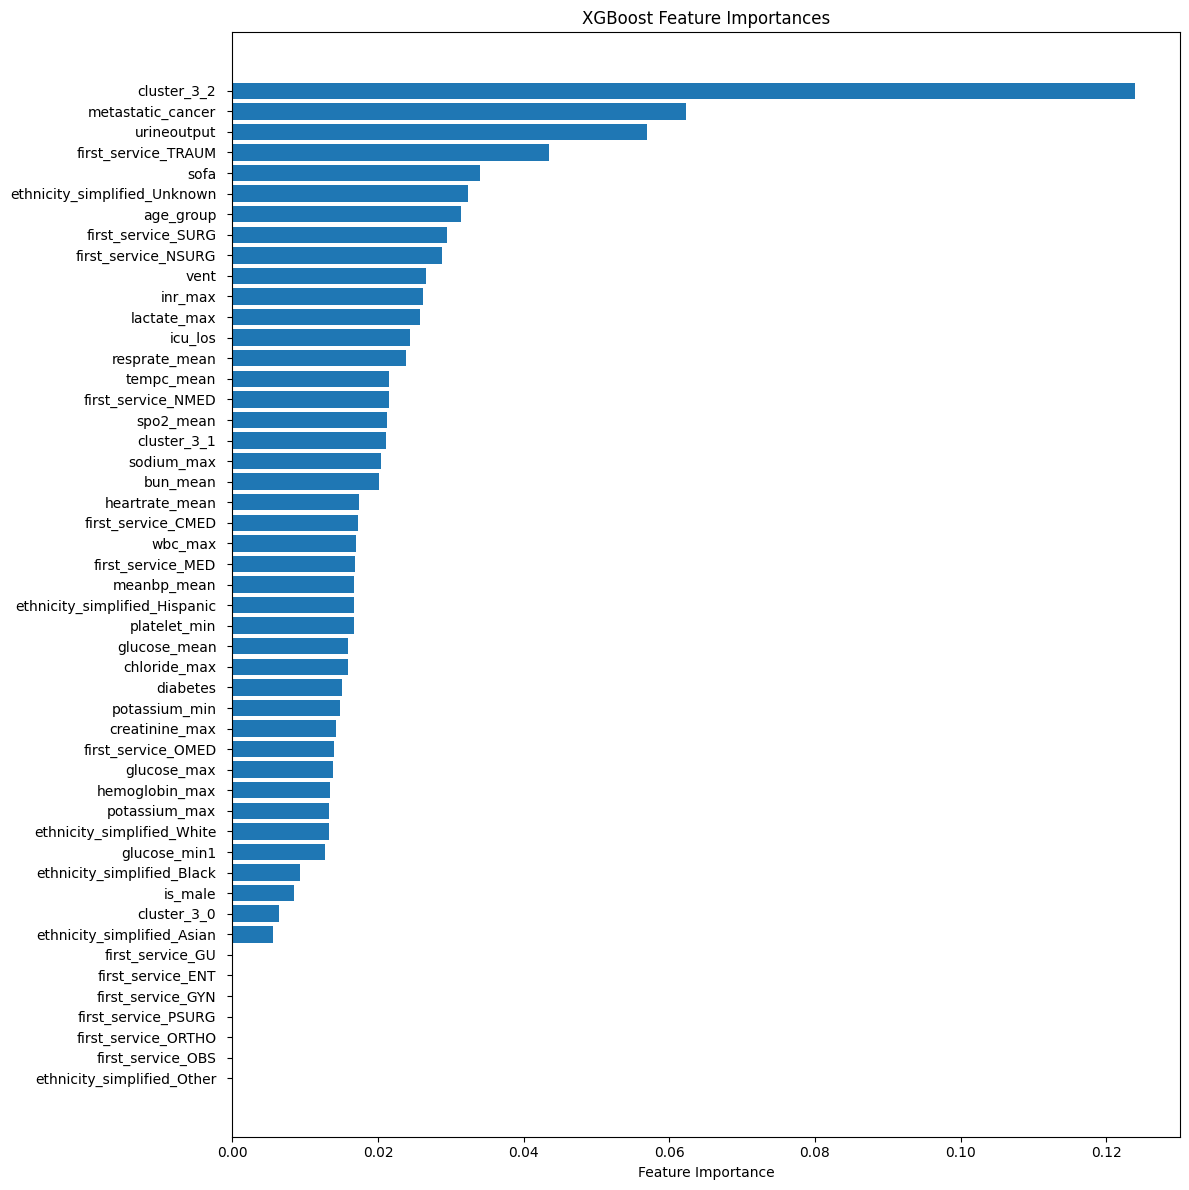

In [17]:
plt.figure(figsize=(12, 12))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.tick_params(axis='y', which='major', labelsize=10, pad=8)
plt.tight_layout()
plt.show()

### Create and fit Random Forest model

**Train Random Forest model**

In [18]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Make predictions & probabilities**

In [19]:
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

**Evaluate Random Forest performance**

In [20]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.8364434687156971
AUC: 0.8402057114827475
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91       733
         1.0       0.73      0.26      0.38       178

    accuracy                           0.84       911
   macro avg       0.79      0.62      0.64       911
weighted avg       0.82      0.84      0.80       911



**Feature importances plot**

In [21]:
importances = rf_clf.feature_importances_
feature_names = X_train.columns

**Plot feature importances**

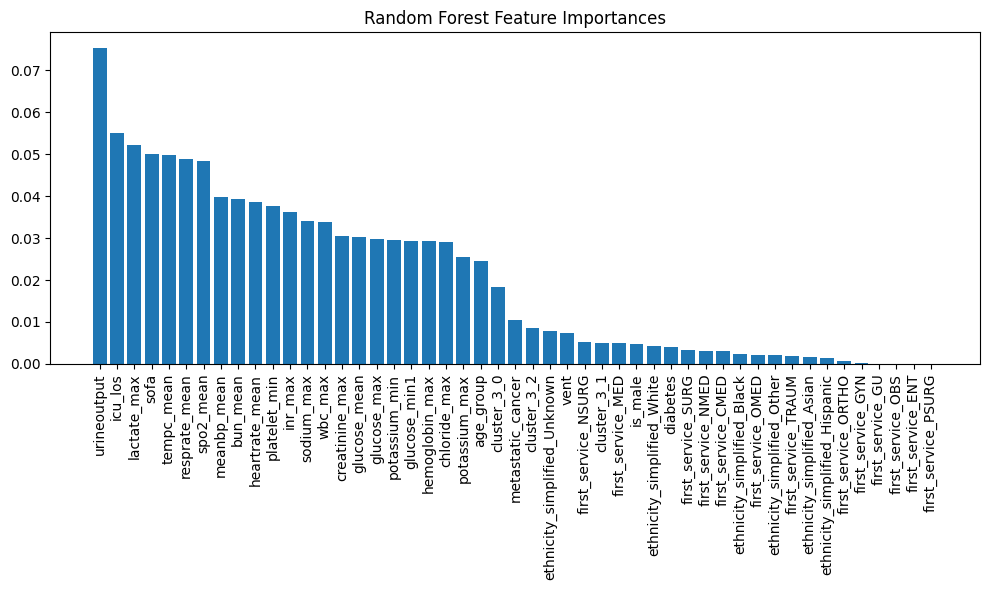

In [22]:
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

### Model comparison summary

| Model                   | Accuracy | AUC    | Feature importance notes                            |
|--------------------------|----------|--------|----------------------------------------------------|
| Logistic Regression      | 0.83     | 0.84   | Relied mainly on clinical and lab features; clusters had minimal effect. |
| XGBoost Classifier       | 0.85     | 0.84   | Cluster (cluster_3_2) was top features, indicating strong value of clustering. |
| Random Forest Classifier | 0.84     | 0.84   | Urine output, ICU LOS and lactate_max dominated; clusters were less important. |



### Conclusion
XGBoost achieved slightly better accuracy and AUC while also prominently utilizing the cluster features, suggesting that combining clustering with prediction improves performance. Logistic Regression and Random Forest performed comparably, but relied more on traditional features.


### Does clustering help improve prediction?

Based on our results, adding the cluster features did slightly improve model performance.

- In the XGBoost model, the clusters (cluster_3_2 and cluster_3_1) were among the most important predictors.

- The Random Forest model showed more modest reliance on the clusters, with similar overall metrics.

This suggests that incorporating clustering into the prediction pipeline can enhance the model by capturing latent patient phenotypes that are not directly reflected in individual clinical variables. Thus, clustering did help improve prediction, especially in more complex models like XGBoost.